In [12]:
import os
from datasets import load_dataset
import torch
import torchaudio
from transformers import AutoProcessor, AutoModel
import numpy as np
from panns_inference import AudioTagging

In [ ]:

# Load the dataset
dataset = load_dataset("lewtun/music_genres_small")

# Check a sample

samples = dataset['train'][0]
print(samples)

{'audio': {'path': None, 'array': array([-3.29642924e-10, -4.74537076e-10,  1.09266698e-08, ...,
       -2.98384890e-01, -3.06825116e-01, -2.82902196e-01]), 'sampling_rate': 44100}, 'song_id': 11704, 'genre_id': 6, 'genre': 'Chiptune / Glitch'}


In [30]:
# Load PANNs model (Cnn14)
model = AudioTagging(checkpoint_path=None, device='cuda')  # Use 'cuda' if you have a GPU

def extract_embeddings(audio_sample):
    """Extract embeddings from a dataset sample."""
    waveform = torch.tensor(audio_sample["audio"]["array"]).float().unsqueeze(0).to("cuda")  # Convert to FloatTensor & move to GPU
    with torch.no_grad():
        embedding, _ = model.inference(waveform)  # ✅ Unpack tuple: (embedding, class_probabilities)
    return embedding  # ✅ Returns the correct feature embeddings

def extract_and_save_embeddings(dataset, save_path="embeddings-for-instruments-task.npy"):
    embeddings = []
    for sample in dataset:
        embeddings.append(extract_embeddings(sample))
    np.save(save_path, np.array(embeddings))
    return save_path

embedding_file = extract_and_save_embeddings(dataset['train'])



Checkpoint path: C:\Users\Prosp/panns_data/Cnn14_mAP=0.431.pth
GPU number: 1


In [42]:
# Load PANNs model (Cnn14)
model = AudioTagging(checkpoint_path=None, device='cuda')  # Use 'cuda' if you have a GPU

def extract_embeddings(audio_sample):
    """Extract embeddings from a dataset sample."""
    waveform = torch.tensor(audio_sample["audio"]["array"]).float().unsqueeze(0).to("cuda")  # Convert to FloatTensor & move to GPU
    with torch.no_grad():
        embedding, _ = model.inference(waveform)  # ✅ Unpack tuple: (embedding, class_probabilities)
    return embedding  # ✅ Returns the correct feature embeddings

def extract_and_save_embeddings(dataset, save_path="embeddings-for-instruments-task.npz"):
    embeddings = []
    for sample in dataset:
        embeddings.append(extract_embeddings(sample))
    np.save(save_path, np.array(embeddings))
    return save_path

embedding_file = extract_and_save_embeddings(dataset['train'])



Checkpoint path: C:\Users\Prosp/panns_data/Cnn14_mAP=0.431.pth
GPU number: 1


In [37]:
# Load embeddings
embeddings = np.load("embeddings-for-instruments-task.npy")

# Remove the extra dimension
embeddings = np.squeeze(embeddings)  # Shape will become (1000, 527)

# Check new shape
print(embeddings.shape)  # Should print (1000, 527)

(1000, 527)


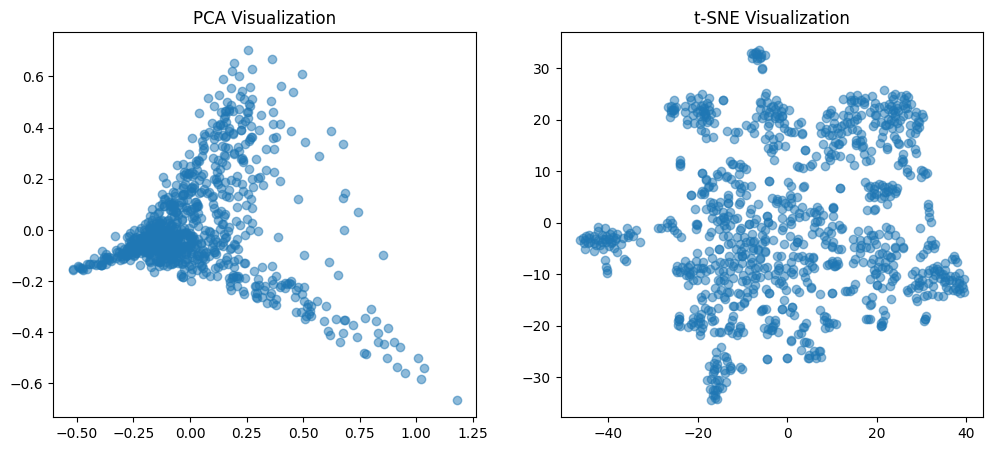

In [41]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE

# Load embeddings
embeddings = np.squeeze(np.load("embeddings-for-instruments-task.npy"))  # Shape: (num_samples, embedding_dim)

# Reduce to 2D using PCA
pca = PCA(n_components=2)
embeddings_pca = pca.fit_transform(embeddings)

# Reduce to 2D using t-SNE
tsne = TSNE(n_components=2, perplexity=30, random_state=42)
embeddings_tsne = tsne.fit_transform(embeddings)

# Plot PCA
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.scatter(embeddings_pca[:, 0], embeddings_pca[:, 1], alpha=0.5)
plt.title("PCA Visualization")

# Plot t-SNE
plt.subplot(1, 2, 2)
plt.scatter(embeddings_tsne[:, 0], embeddings_tsne[:, 1], alpha=0.5)
plt.title("t-SNE Visualization")

plt.show()


In [46]:
# 1. Reload the dataset to get labels
dataset = load_dataset("lewtun/music_genres_small")
train_data = dataset['train']

# 2. Load your saved embeddings
embeddings = np.load("embeddings-for-instruments-task.npy")
embeddings = np.squeeze(embeddings)  # Shape (1000, 527)

# 3. Verify the order is preserved (critical!)
assert len(embeddings) == len(train_data), "Mismatch between embeddings and dataset length"

# 4. Extract labels in the same order as embeddings were generated
labels = [sample['genre'] for sample in train_data]

# 5. Now you have parallel arrays:
# - embeddings[i] corresponds to labels[i]
print(f"First 5 labels: {labels[:5]}")
print(f"First embedding shape: {embeddings[0].shape}")

First 5 labels: ['International', 'International', 'Pop', 'International', 'Electronic']
First embedding shape: (527,)


In [ ]:
def extract_and_save_embeddings_with_labels(dataset, save_prefix="music_genre"):
    embeddings = []
    labels = []
    
    for sample in dataset:
        embeddings.append(extract_embeddings(sample))
        labels.append(sample['genre'])
    
    # Save as numpy arrays
    np.save(f"{save_prefix}_embeddings.npy", np.array(embeddings))
    np.save(f"{save_prefix}_labels.npy", np.array(labels))
    
    # Alternative: Save as dictionary in npz format
    np.savez(f"{save_prefix}_data.npz", embeddings=embeddings, labels=labels)
    
    return embeddings, labels



AttributeError: module 'numpy' has no attribute 'squeuze'

In [48]:
# Usage
embeddings, labels = extract_and_save_embeddings_with_labels(dataset['train'])
embeddings = np.squeeze(embeddings)

In [ ]:
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split

# 1. Encode string labels to numerical values
label_encoder = LabelEncoder()
encoded_labels = label_encoder.fit_transform(labels)

# 2. Split into train/test sets
X_train, X_test, y_train, y_test = train_test_split(
    embeddings,
    encoded_labels,
    test_size=0.2,
    random_state=42,
    stratify=encoded_labels  # Important for imbalanced datasets
)


Test accuracy: 0.53


In [ ]:
# 3. Now you can train your classifier
from sklearn.ensemble import RandomForestClassifier

clf = RandomForestClassifier(n_estimators=100)
clf.fit(X_train, y_train)

# 4. Evaluate
accuracy = clf.score(X_test, y_test)
print(f"Test accuracy: {accuracy:.2f}")

# To get back original genre names:
predicted_genres = label_encoder.inverse_transform(clf.predict(X_test))

1000


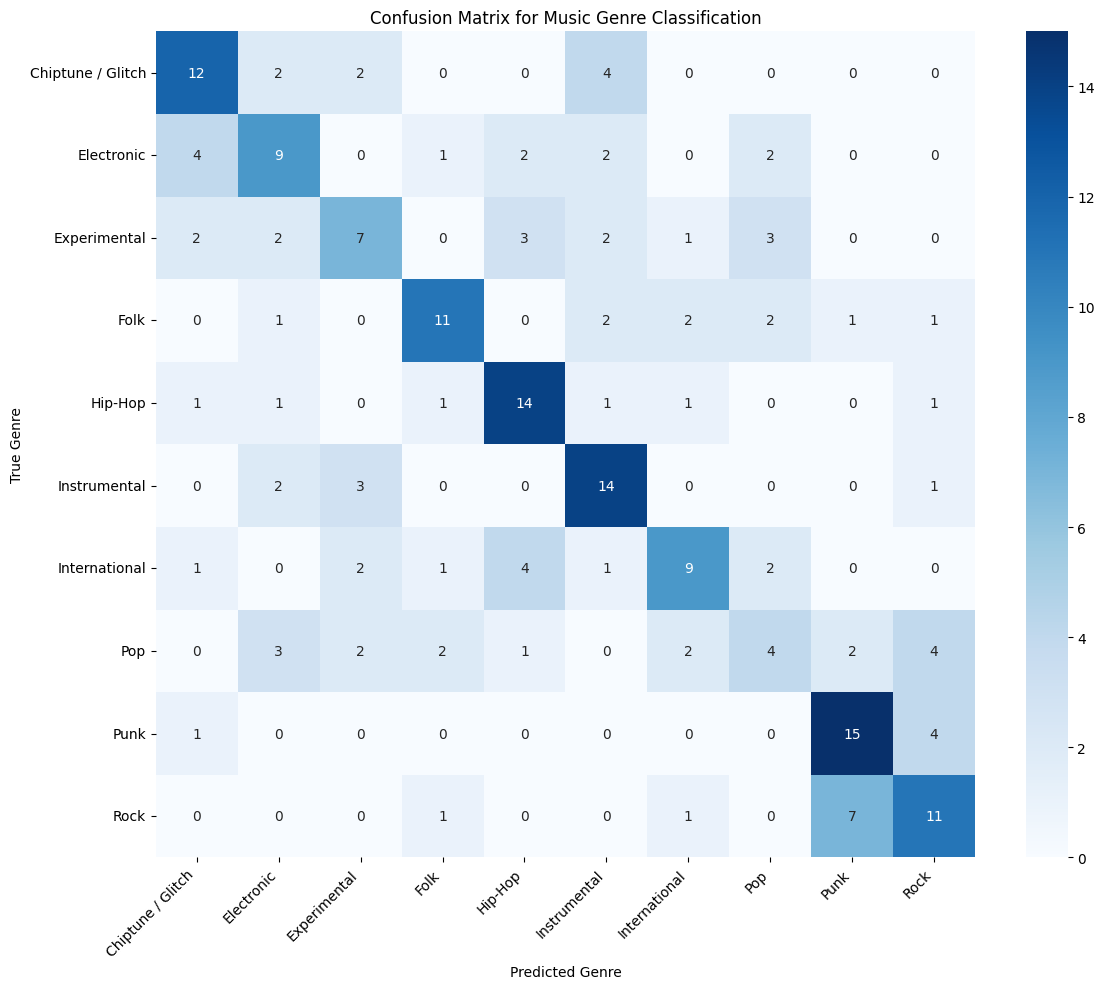

In [53]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix

# Get predictions
y_pred = clf.predict(X_test)

# Generate confusion matrix
cm = confusion_matrix(y_test, y_pred)

# Get class names in original string format
class_names = label_encoder.classes_

# Plotting
plt.figure(figsize=(12, 10))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=class_names, 
            yticklabels=class_names)

plt.title('Confusion Matrix for Music Genre Classification')
plt.xlabel('Predicted Genre')
plt.ylabel('True Genre')
plt.xticks(rotation=45, ha='right')
plt.yticks(rotation=0)
plt.tight_layout()
plt.show()

In [54]:
from sklearn.metrics import classification_report

print(classification_report(
    y_test, 
    y_pred, 
    target_names=class_names
))

                   precision    recall  f1-score   support

Chiptune / Glitch       0.57      0.60      0.59        20
       Electronic       0.45      0.45      0.45        20
     Experimental       0.44      0.35      0.39        20
             Folk       0.65      0.55      0.59        20
          Hip-Hop       0.58      0.70      0.64        20
     Instrumental       0.54      0.70      0.61        20
    International       0.56      0.45      0.50        20
              Pop       0.31      0.20      0.24        20
             Punk       0.60      0.75      0.67        20
             Rock       0.50      0.55      0.52        20

         accuracy                           0.53       200
        macro avg       0.52      0.53      0.52       200
     weighted avg       0.52      0.53      0.52       200



KNN Test Accuracy: 0.43

Classification Report:
                   precision    recall  f1-score   support

Chiptune / Glitch       0.55      0.55      0.55        20
       Electronic       0.30      0.35      0.33        20
     Experimental       0.36      0.40      0.38        20
             Folk       0.52      0.70      0.60        20
          Hip-Hop       0.60      0.60      0.60        20
     Instrumental       0.38      0.30      0.33        20
    International       0.50      0.30      0.38        20
              Pop       0.19      0.20      0.20        20
             Punk       0.48      0.65      0.55        20
             Rock       0.50      0.30      0.38        20

         accuracy                           0.43       200
        macro avg       0.44      0.43      0.43       200
     weighted avg       0.44      0.43      0.43       200



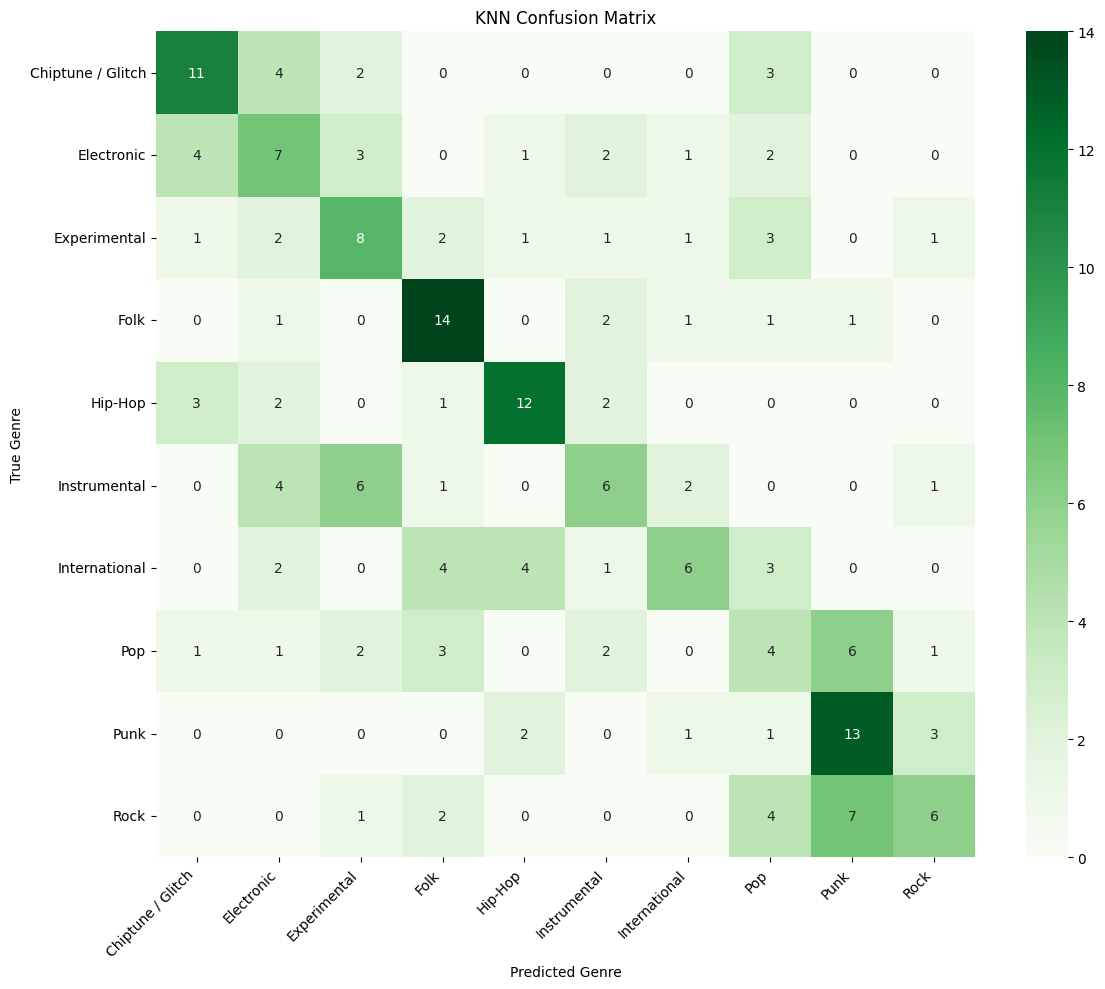


Model Comparison:
- Random Forest Accuracy: 0.53
- KNN Accuracy: 0.43


In [58]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

## 1. Initialize and train KNN classifier
knn = KNeighborsClassifier(n_neighbors=10)  # You can adjust n_neighbors
knn.fit(X_train, y_train)

## 2. Make predictions
y_pred_knn = knn.predict(X_test)

## 3. Evaluate performance
# Accuracy
knn_accuracy = accuracy_score(y_test, y_pred_knn)
print(f"KNN Test Accuracy: {knn_accuracy:.2f}")

# Classification report
print("\nClassification Report:")
print(classification_report(y_test, y_pred_knn, target_names=label_encoder.classes_))

## 4. Plot confusion matrix
plt.figure(figsize=(12, 10))
cm_knn = confusion_matrix(y_test, y_pred_knn)
sns.heatmap(cm_knn, annot=True, fmt='d', cmap='Greens',
            xticklabels=label_encoder.classes_,
            yticklabels=label_encoder.classes_)
plt.title('KNN Confusion Matrix')
plt.xlabel('Predicted Genre')
plt.ylabel('True Genre')
plt.xticks(rotation=45, ha='right')
plt.yticks(rotation=0)
plt.tight_layout()
plt.show()

## 5. Compare with Random Forest
print("\nModel Comparison:")
print(f"- Random Forest Accuracy: {accuracy:.2f}")
print(f"- KNN Accuracy: {knn_accuracy:.2f}")

In [66]:
from transformers import Wav2Vec2Model, Wav2Vec2FeatureExtractor
import torch
import torchaudio
import numpy as np
from datasets import load_dataset
from tqdm import tqdm

# Initialize model and processor
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model_name = "facebook/wav2vec2-base"
feature_extractor = Wav2Vec2FeatureExtractor.from_pretrained(model_name)
model = Wav2Vec2Model.from_pretrained(model_name).to(device)

def get_embeddings_from_audio(audio_array, sample_rate=16000):
    """Process raw audio array to get embeddings"""
    waveform = torch.tensor(audio_array).float()
    
    # Resample if necessary
    if sample_rate != 16000:
        resampler = torchaudio.transforms.Resample(
            orig_freq=sample_rate,
            new_freq=16000
        )
        waveform = resampler(waveform)
    
    # Process with feature extractor and model
    inputs = feature_extractor(
        waveform.numpy(), 
        sampling_rate=16000, 
        return_tensors="pt"
    ).to(device)
    
    with torch.no_grad():
        outputs = model(**inputs)
    
    # Mean pooling over time dimension
    return outputs.last_hidden_state.mean(dim=1).cpu().numpy()

def extract_dataset_embeddings(dataset, batch_size=8):
    """Process entire dataset"""
    embeddings = []
    labels = []
    
    for i in tqdm(range(0, len(dataset)), desc="Extracting embeddings"):
        sample = dataset[i]
        
        # Get audio data and label
        audio_data = sample["audio"]["array"]
        sample_rate = sample["audio"]["sampling_rate"]
        label = sample["genre"]
        
        # Get embedding
        embedding = get_embeddings_from_audio(audio_data, sample_rate)
        
        embeddings.append(embedding)
        labels.append(label)
    
    # Stack all embeddings
    embeddings = np.vstack(embeddings)
    return embeddings, labels

In [67]:
# Usage example
embeddings_wav2vec, labels = extract_dataset_embeddings(dataset['train'])

# Save embeddings and labels
np.save("wav2vec2_embeddings.npy", embeddings_wav2vec)
np.save("wav2vec2_labels.npy", np.array(labels))

Extracting embeddings: 100%|██████████| 1000/1000 [10:04<00:00,  1.65it/s]


In [69]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split

# Load saved embeddings if needed
# embeddings_wav2vec = np.load("wav2vec2_embeddings.npy")
# labels = np.load("wav2vec2_labels.npy")

# Encode labels
label_encoder = LabelEncoder()
y = label_encoder.fit_transform(labels)

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(
    embeddings_wav2vec,
    y,
    test_size=0.2,
    random_state=42,
    stratify=y
)

# Train and evaluate
clf = RandomForestClassifier(n_estimators=100)
clf.fit(X_train, y_train)
accuracy = clf.score(X_test, y_test)
print(f"Accuracy: {accuracy:.4f}")

Accuracy: 0.3750


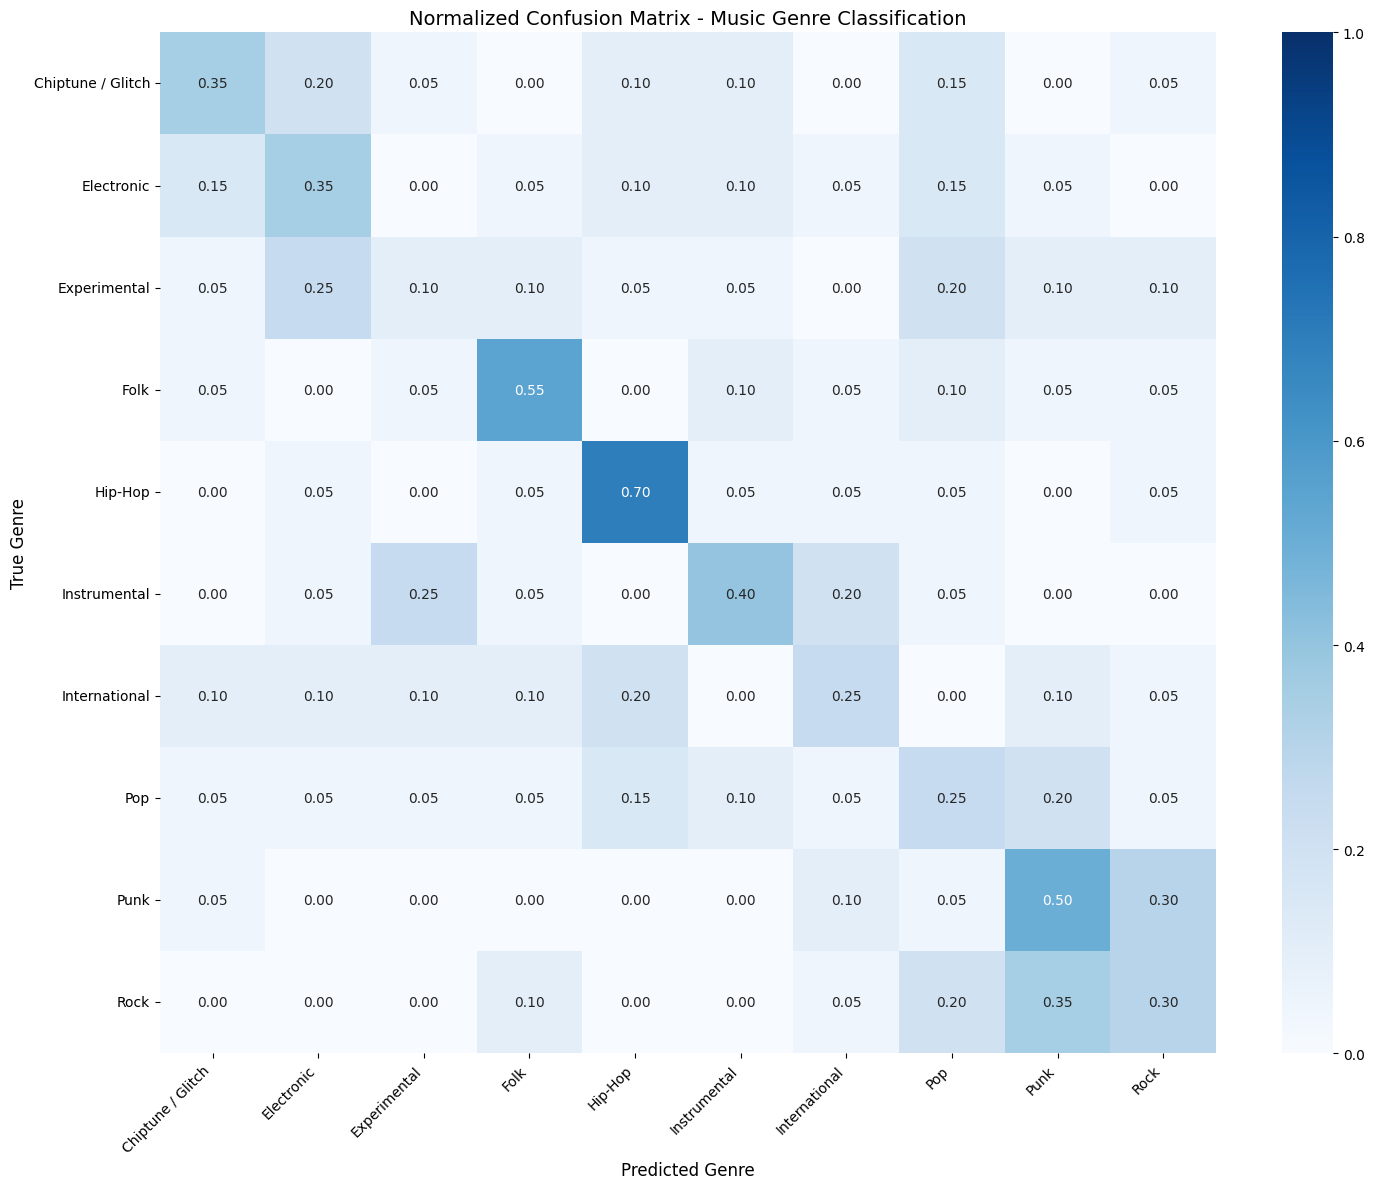

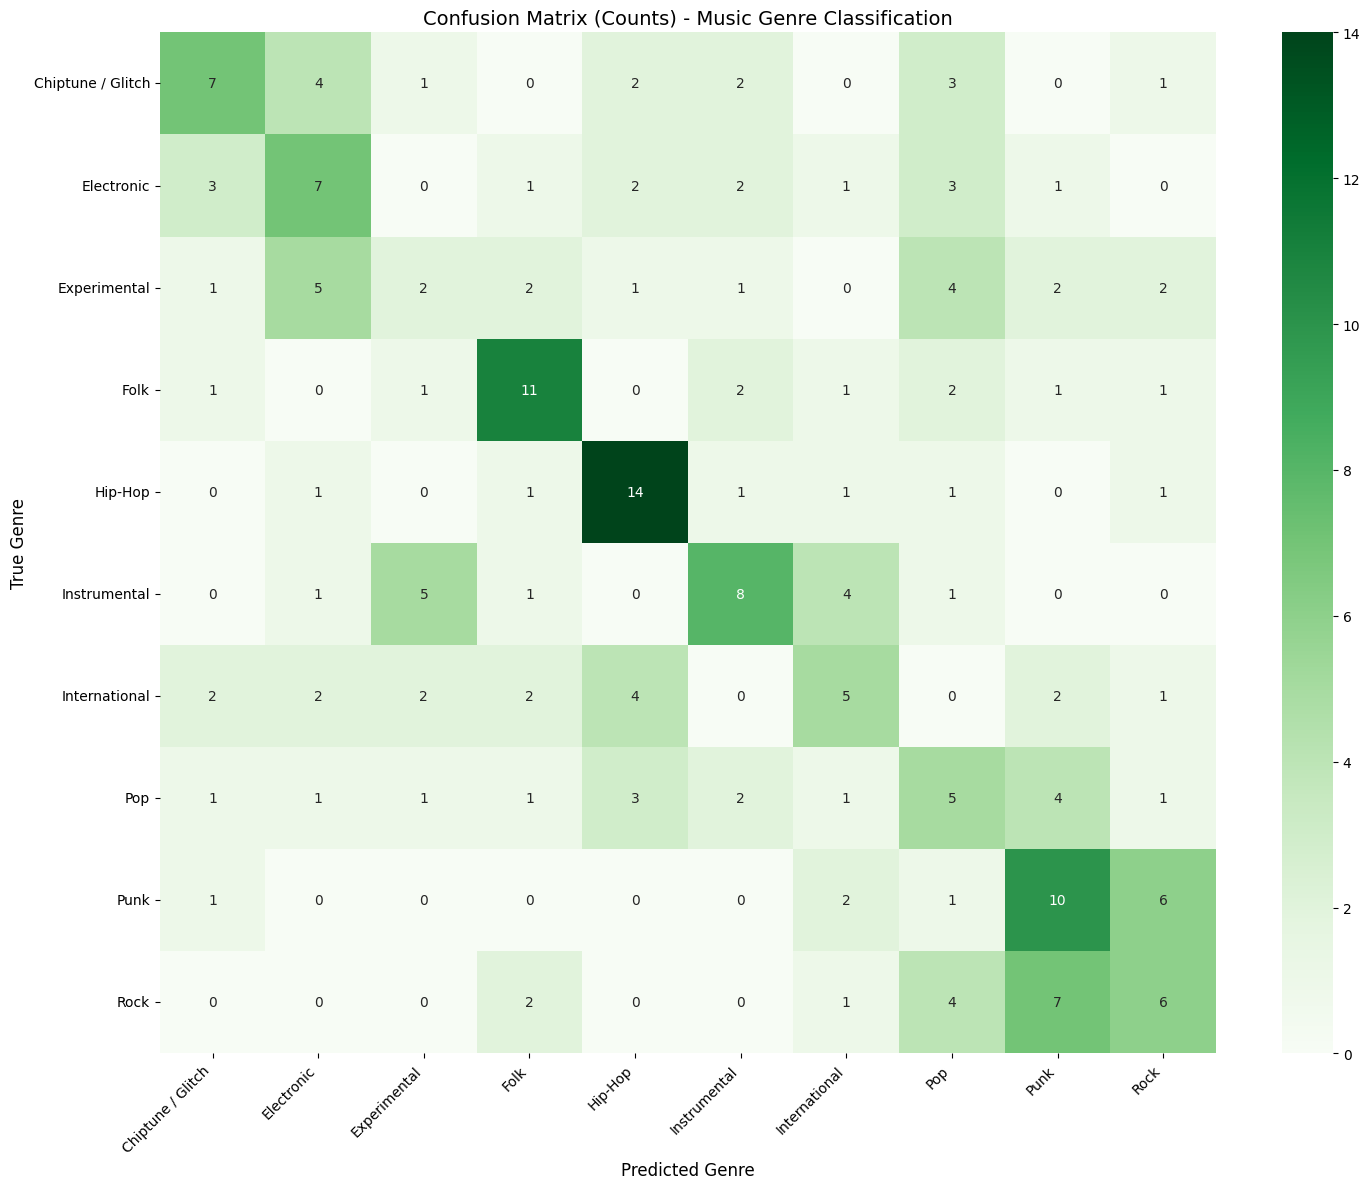

In [70]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix
import numpy as np

# Assuming you have:
# - clf: your trained RandomForest classifier
# - X_test, y_test: test data
# - label_encoder: your LabelEncoder instance

# Get predictions
y_pred = clf.predict(X_test)

# Generate confusion matrix
cm = confusion_matrix(y_test, y_pred)

# Normalize the confusion matrix (optional)
cm_normalized = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

# Get class names
class_names = label_encoder.classes_

# Create figure
plt.figure(figsize=(15, 12))

# Plot confusion matrix
sns.heatmap(cm_normalized, 
            annot=True, 
            fmt=".2f", 
            cmap="Blues",
            xticklabels=class_names,
            yticklabels=class_names,
            vmin=0, vmax=1)

# Add labels and title
plt.title('Normalized Confusion Matrix - Music Genre Classification', fontsize=14)
plt.xlabel('Predicted Genre', fontsize=12)
plt.ylabel('True Genre', fontsize=12)
plt.xticks(rotation=45, ha='right', fontsize=10)
plt.yticks(rotation=0, fontsize=10)

# Add colorbar
cbar = plt.gcf().axes[-1]
cbar.tick_params(labelsize=10)

plt.tight_layout()
plt.show()

# Print raw numbers version
plt.figure(figsize=(15, 12))
sns.heatmap(cm, 
            annot=True, 
            fmt="d", 
            cmap="Greens",
            xticklabels=class_names,
            yticklabels=class_names)

plt.title('Confusion Matrix (Counts) - Music Genre Classification', fontsize=14)
plt.xlabel('Predicted Genre', fontsize=12)
plt.ylabel('True Genre', fontsize=12)
plt.xticks(rotation=45, ha='right', fontsize=10)
plt.yticks(rotation=0, fontsize=10)
plt.tight_layout()
plt.show()